# Case_study_IL&FS Technologies
## Supervised Learning
## Loan_prediction

**Python version-3.x**

**Author- Nimish Bhushan**

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'Loan_status'`, will be our target label 

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the loan dataset
data = pd.read_csv("ilfs.csv")
data['Loan_Amount_Term'] = data.Loan_Amount_Term.astype(object)
data['Credit_History'] = data.Credit_History.astype(object)
data['Loan_Status'] = data['Loan_Status'].astype('category')
display(data.head(n=5))

,Gender,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,1,Graduate,No,4583,128,360,1,Rural,N
1,Male,0,Graduate,Yes,3000,66,360,1,Urban,Y
2,Male,0,Not Graduate,No,2583,120,360,1,Urban,Y
3,Male,0,Graduate,No,6000,141,360,1,Urban,Y
4,Male,2,Graduate,Yes,5417,267,360,1,Urban,Y


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals

Total number of records: 480
Loan Approved: 332
Loan Not aprroved:148
Percentage of people who got loan: 69.16666666666667%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


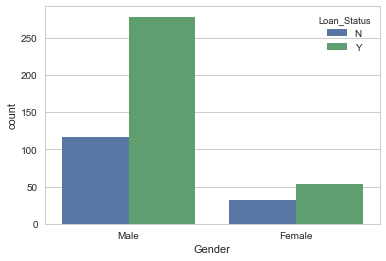

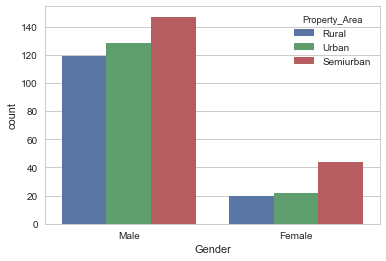

In [2]:
#Total number of records
n_records = len(data)

#Number of records where loan approved
n_loan_approved = len(data[data['Loan_Status'] == 'Y'])


# Number of records where loan not approved
n_loan_notapproved = len(data[data['Loan_Status'] == 'N'])

# Percentage of individuals whose loan got approved
Loan_percent = 100 * n_loan_approved / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Loan Approved: {}".format(n_loan_approved))
print("Loan Not aprroved:{}".format(n_loan_notapproved))
print("Percentage of people who got loan: {}%".format(Loan_percent))
sns.set(style="whitegrid", color_codes=True)
sns.countplot("Gender",hue='Loan_Status', data=data)
plt.show()
sns.countplot("Gender",hue='Property_Area', data=data)
plt.show()


The above viz gives us a rough idea about how data is distributed by gender by property_type and which group got how many loans approved. Clearly there is a high class imbalance

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**.This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the Loan dataset two features fit this description: '`ApplicantIncome'` and `'LoanAmount'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

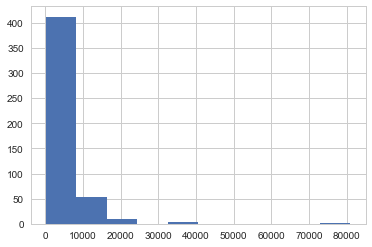

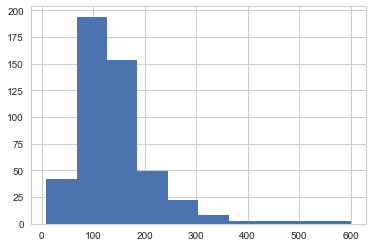

Y    332
N    148
Name: Loan_Status, dtype: int64

In [3]:
# Split the data into features and target label
income_raw = data['ApplicantIncome']
Loan_raw = data['LoanAmount']
features_raw = data.drop('Loan_Status', axis = 1)
target = data['Loan_Status']

# Visualize skewed continuous features of original data
income_raw.hist()
plt.show()
Loan_raw.hist()
plt.show()
data.Loan_Status.value_counts()

For highly-skewed feature distributions, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

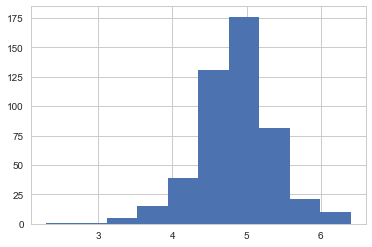

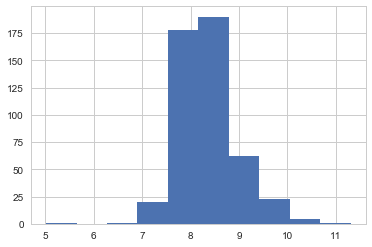

In [4]:
# Log-transform the skewed features
skewed = ['ApplicantIncome', 'LoanAmount']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x+1))

features_log_transformed.LoanAmount.hist()
plt.show()
features_log_transformed.ApplicantIncome.hist()
plt.show()

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. However, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['ApplicantIncome', 'LoanAmount']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,Gender,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,1,Graduate,No,0.543052,0.624322,360,1,Rural
1,Male,0,Graduate,Yes,0.475649,0.464381,360,1,Urban
2,Male,0,Not Graduate,No,0.451844,0.608691,360,1,Urban
3,Male,0,Graduate,No,0.585909,0.647763,360,1,Urban
4,Male,2,Graduate,Yes,0.569648,0.802831,360,1,Urban


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for target label, we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'Loan_Status'` to numerical entries.
   - Set records with "N" to `0` and records with "Y" to `1`.

In [6]:
#One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform,drop_first=True)

#Encode the 'Loan_Status' data to numerical values
target.astype(str)
target = target.apply(lambda x: 1 if x == 'Y' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

#encoded feature names
print (encoded)
display(features_final.tail(n=10))

19 total features after one-hot encoding.
['ApplicantIncome', 'LoanAmount', 'Gender_Male', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Loan_Amount_Term_60', 'Loan_Amount_Term_84', 'Loan_Amount_Term_120', 'Loan_Amount_Term_180', 'Loan_Amount_Term_240', 'Loan_Amount_Term_300', 'Loan_Amount_Term_360', 'Loan_Amount_Term_480', 'Credit_History_1', 'Property_Area_Semiurban', 'Property_Area_Urban']


,ApplicantIncome,LoanAmount,Gender_Male,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Loan_Amount_Term_60,Loan_Amount_Term_84,Loan_Amount_Term_120,Loan_Amount_Term_180,Loan_Amount_Term_240,Loan_Amount_Term_300,Loan_Amount_Term_360,Loan_Amount_Term_480,Credit_History_1,Property_Area_Semiurban,Property_Area_Urban
470,0.507972,0.695972,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
471,0.696183,0.953612,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
472,0.495557,0.697379,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
473,0.520891,0.673829,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0
474,0.487497,0.583193,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
475,0.470256,0.481952,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
476,0.525569,0.344478,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
477,0.633101,0.789732,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
478,0.623159,0.716272,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
479,0.543052,0.633606,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 384 samples.
Testing set has 96 samples.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate three different algorithms, and determine which is best at modeling the data. Three different algorithms will be used to test performance

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest)
- K-Nearest Neighbors (KNeighbors)
- Support Vector Machines (SVM)
- Logistic Regression

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   

In [8]:
#Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will need to implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model
  - Use the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively

In [9]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models

clf_A = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_split=15, random_state=1)
clf_B = SVC(random_state = 1)
clf_C = AdaBoostClassifier(random_state = 1)

samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = int(len(X_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 4 samples.
RandomForestClassifier trained on 38 samples.
RandomForestClassifier trained on 384 samples.
SVC trained on 4 samples.
SVC trained on 38 samples.
SVC trained on 384 samples.
AdaBoostClassifier trained on 4 samples.
AdaBoostClassifier trained on 38 samples.
AdaBoostClassifier trained on 384 samples.


RandomForestClassifier


,1%,10%,100%
acc_test,0.635417,0.750000,0.760417
acc_train,0.723333,0.790000,0.856667
f_test,0.685393,0.763359,0.774278
f_train,0.765702,0.819672,0.874271
pred_time,0.032464,0.015626,0.028623
train_time,0.154520,0.180097,0.210928


SVC


,1%,10%,100%
acc_test,0.635417,0.635417,0.770833
acc_train,0.723333,0.723333,0.813333
f_test,0.685393,0.685393,0.776081
f_train,0.765702,0.765702,0.837989
pred_time,0.000000,0.000000,0.007999
train_time,0.000000,0.000000,0.011065


AdaBoostClassifier


,1%,10%,100%
acc_test,0.552083,0.645833,0.708333
acc_train,0.626667,0.763333,0.870000
f_test,0.644699,0.718850,0.753623
f_train,0.736196,0.843661,0.886076
pred_time,0.000000,0.015685,0.011436
train_time,0.004089,0.097424,0.104696


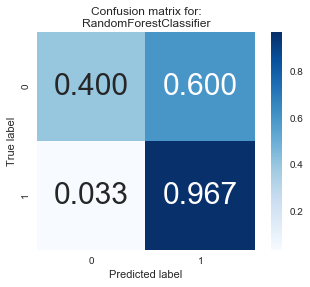

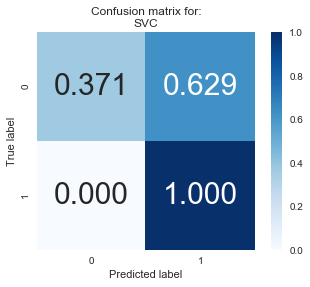

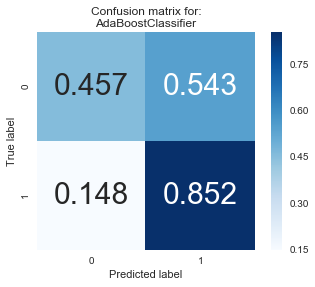

In [10]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__))

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

In [11]:
#Import 'GridSearchCV', 'make_scorer'.

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state = 1)


# Create the parameters list we wish to tune
parameters = {'n_estimators':[50,75], 
              'learning_rate':[0.001, 0.01, 0.1, 1.0],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

# Make an fbeta_score scoring object using make_scorer()

scorer = make_scorer(fbeta_score,beta=0.5)

#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.6771
F-score on testing data: 0.7544

Optimized Model
------
Final accuracy score on the testing data: 0.7604
Final F-score on the testing data: 0.7808


#### Results:

|     Metric     | Unoptimized Model | Optimized Model 
| :------------: | :---------------: | :-------------: 
| Accuracy Score |   0.6771          |   0.7604      |  
| F-score        |   0.7544          |   0.7808      |        




* These scores are clearly better than unoptimized model. Accuracy has improved significantly. However, parameter tuning takes long time to run hence we should carefully select parameters to be tuned and appropriate values. In case of large volume of data, this issue can be significant.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the Loan data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual should or would get a loan or not

###Feature Relevance Observation
-Of all the features available, we will select the top 5 features that are most helpful in predicting the outcome and test the model for accuracy and f-score on full as well as this reducedd data

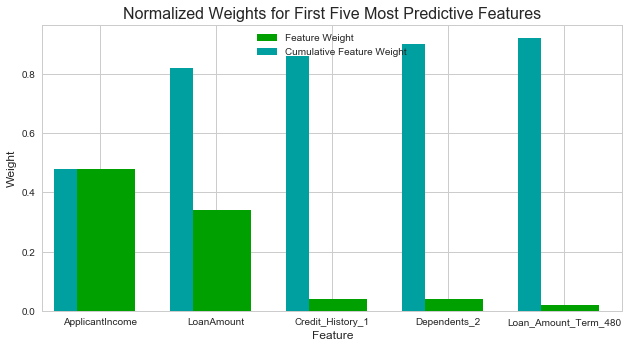

In [12]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start1 = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end1 = time()
# Make new predictions
start2 = time()
reduced_predictions = clf.predict(X_test_reduced)
end2 = time()

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7604
F-score on testing data: 0.7808

Final Model trained on reduced data
------
Accuracy on testing data: 0.7500
F-score on testing data: 0.7724


1. Model on reduced data has slighly lower accuracy and F-score but the feature space consists of just 5 top features. I think that it is a much more practical model as compared to the one with full feature space. Firstly, as the data size will increase reduced data size model might come closer to full data model or even outperform it. This is due to the fact that when we increase the feature space, we also need more and more data for training. Hence, large data and reduced feature space will favour reduced data model much more. 

2. Training time for reduced data model is comparitively lower as compared to the one with full data or feature space. As, the data size would grow, time taken for computation would also increase hence having a reduced feature space would be favourable overall to achieve a balance of time